# **TRAIN DATA**

###Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tools import eval_measures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import datetime
pd.set_option('display.max_rows', 500)
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/GoML/Data')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


###Get Data

In [ ]:
sj_train = pd.read_csv("sj_data_smooth.csv")

In [ ]:
iq_train = pd.read_csv("iq_data_smooth.csv")

In [ ]:
sj_train.head()

In [ ]:
#Adding avg_temp,max_temp,prep_avg var an average of station_avg and reanalysis_avg
sj_train['reanalysis_avg_temp_c']=sj_train['reanalysis_avg_temp_k']-273
iq_train['reanalysis_avg_temp_c']=iq_train['reanalysis_avg_temp_k']-273

sj_train['reanalysis_max_air_temp_c']=sj_train['reanalysis_max_air_temp_k']-273
iq_train['reanalysis_max_air_temp_c']=iq_train['reanalysis_max_air_temp_k']-273

sj_train['avg_temp']=(sj_train['reanalysis_avg_temp_c']+sj_train['station_avg_temp_c'])/2
iq_train['avg_temp']=(iq_train['reanalysis_avg_temp_c']+iq_train['station_avg_temp_c'])/2

sj_train['max_temp']=(sj_train['station_max_temp_c']+sj_train['reanalysis_max_air_temp_c'])/2
iq_train['max_temp']=(iq_train['station_max_temp_c']+iq_train['reanalysis_max_air_temp_c'])/2

sj_train['prep_avg']=(sj_train['station_precip_mm']+sj_train['reanalysis_sat_precip_amt_mm'])/2
iq_train['prep_avg']=(iq_train['station_precip_mm']+iq_train['reanalysis_sat_precip_amt_mm'])/2


In [ ]:
sj_train.head()

###Visualization (optional)

In [ ]:
def scaler(x):
  return (x - x.min())/(x.max() - x.min())

In [ ]:
# sj_train.dtypes

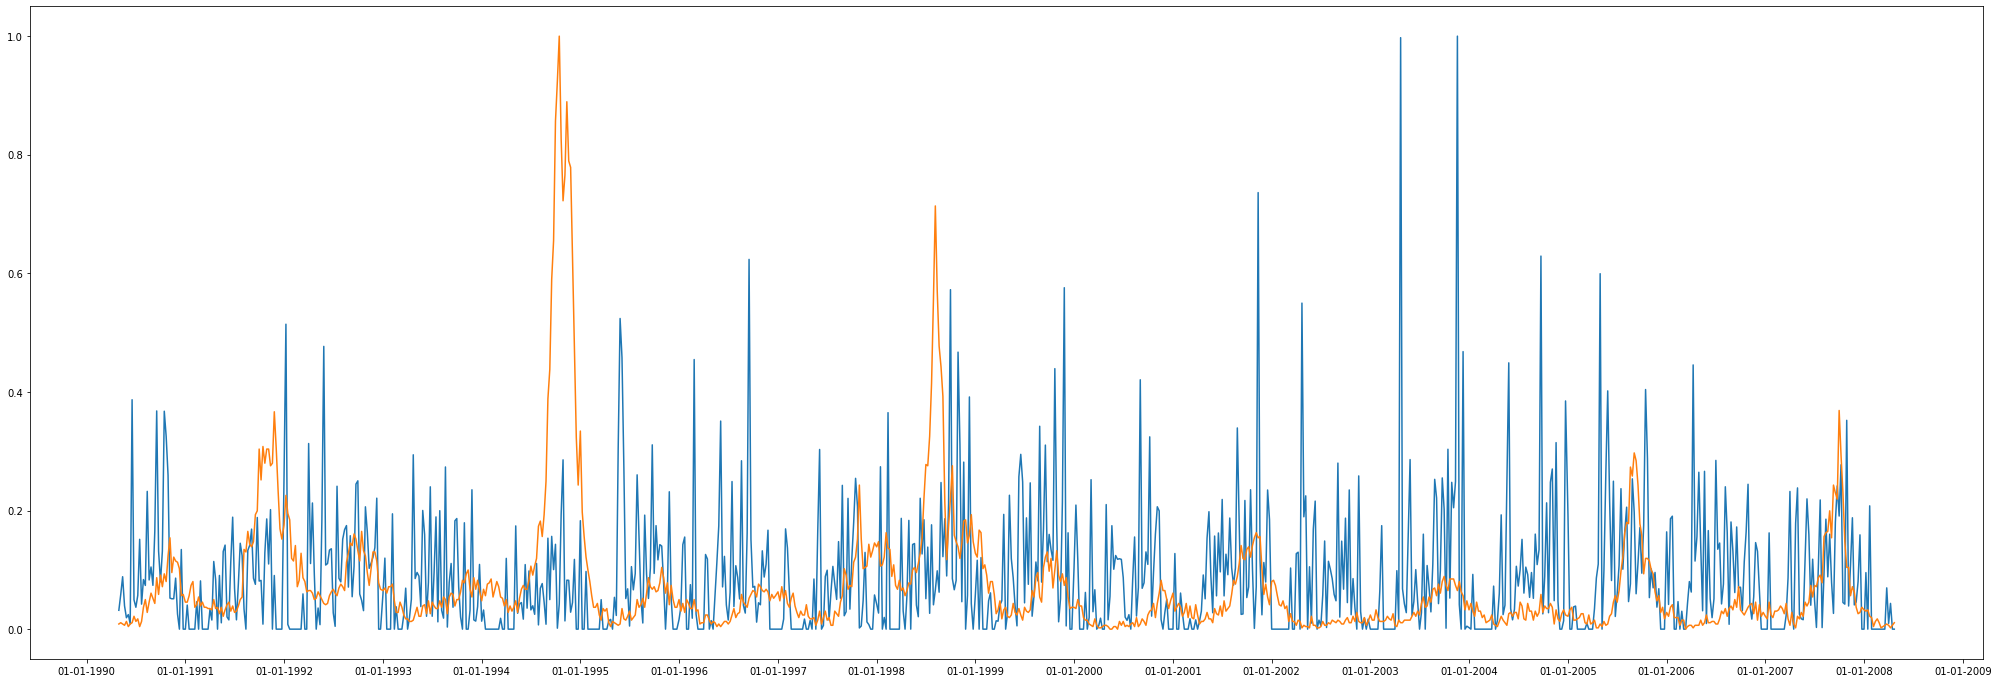

In [ ]:
# import matplotlib.dates as mdates
# plt.figure(figsize=(35,12))
# # plt.plot(sj_year["week_start_date"],scaler(sj_year["precipitation_amt_mm"]),label="precep")
# # plt.plot(sj_train["week_start_date"],scaler(sj_train["station_max_temp_c"]),label="temp")
# plt.plot(pd.to_datetime(sj_train["week_start_date"]),scaler(sj_train["precipitation_amt_mm"]),label="prep")
# plt.plot(pd.to_datetime(sj_train["week_start_date"]),scaler(sj_train["total_cases"]),label="cases")
# ax = plt.gca()

# # # ax.xaxis.set_major_locator(mdates.MonthLocator())
# # # ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))


# ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# # plt.gcf().autofmt_xdate() # Rotation
# # plt.legend()
# plt.show()

###Lag Function 

In [ ]:
def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n) 
    else:
        x = pd.Series(x)
        return x.shift(n) 

    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

###Introducing new columns (ie avg of reanalysis and station)



Avg of avg reanalysis and avg station temperature:

In [ ]:
sj_train["reanalysis_avg_temp_c"]=sj_train["reanalysis_avg_temp_k"]-273.15
sj_train["avg_reanalyis_station"]=(sj_train["reanalysis_avg_temp_c"]+sj_train["station_avg_temp_c"])/2



iq_train["reanalysis_avg_temp_c"]=iq_train["reanalysis_avg_temp_k"]-273.15
iq_train["avg_reanalyis_station"]=(iq_train["reanalysis_avg_temp_c"]+iq_train["station_avg_temp_c"])/2




Avg of max reanalysis temp and max station temp:

In [ ]:
sj_train["reanalysis_max_air_temp_c"]=sj_train["reanalysis_max_air_temp_k"]-273.15
sj_train["avg_max_reanalyis_station"]=(sj_train["reanalysis_max_air_temp_c"]+sj_train["station_max_temp_c"])/2


iq_train["reanalysis_max_air_temp_c"]=iq_train["reanalysis_max_air_temp_k"]-273.15
iq_train["avg_max_reanalyis_station"]=(iq_train["reanalysis_max_air_temp_c"]+iq_train["station_max_temp_c"])/2


Avg of reanalysis precipitation and station precipitation:

In [ ]:
sj_train["avg_prep_reanalyis_station"]=(sj_train["station_precip_mm"]+sj_train["reanalysis_sat_precip_amt_mm"])/2

iq_train["avg_prep_reanalyis_station"]=(iq_train["station_precip_mm"]+iq_train["reanalysis_sat_precip_amt_mm"])/2


### **Random forest: Looping through each lag variables and finding the best lag number by random forest model building** (optional)

**lag** (Looping through each variable for generating lag) (specially for training purpose)

Avg temp

In [ ]:
for i in range (1,21):
  col_name=str('avg_temp_lag_'+str(i))
  sj_train[col_name]=lag(sj_train["avg_reanalyis_station"],i).bfill()
  # sj_train[col_name]=sj_train[col_name].fillna(np.mean(sj_train[col_name]))

for i in range (1,21):
  col_name=str('avg_temp_lag_'+str(i))
  iq_train[col_name]=lag(iq_train["avg_reanalyis_station"],i).bfill()
  # iq_train[col_name]=iq_train[col_name].fillna(np.mean(iq_train[col_name]))

Max temp

In [ ]:
for i in range (1,21):
  col_name=str('max_temp_lag_'+str(i))
  sj_train[col_name]=lag(sj_train["avg_max_reanalyis_station"],i).bfill()
  # sj_train[col_name]=sj_train[col_name].fillna(np.mean(sj_train[col_name]))

for i in range (1,21):
  col_name=str('max_temp_lag_'+str(i))
  iq_train[col_name]=lag(iq_train["avg_max_reanalyis_station"],i).bfill()
  # iq_train[col_name]=iq_train[col_name].fillna(np.mean(iq_train[col_name]))

Specific humidity

In [ ]:
for i in range (1,21):
  col_name=str('specific_lag_'+str(i))
  sj_train[col_name]=lag(sj_train["reanalysis_specific_humidity_g_per_kg"],i).bfill()
  # sj_train[col_name]=sj_train[col_name].fillna(np.mean(sj_train[col_name]))

for i in range (1,21):
  col_name=str('specific_lag_'+str(i))
  iq_train[col_name]=lag(iq_train["reanalysis_specific_humidity_g_per_kg"],i).bfill()
  # iq_train[col_name]=iq_train[col_name].fillna(np.mean(iq_train[col_name]))

Precipitation lag

In [ ]:
for i in range (1,53):
  col_name=str('prep_lag_'+str(i))
  sj_train[col_name]=lag(sj_train["avg_prep_reanalyis_station"],i).bfill()
  # sj_train[col_name]=sj_train[col_name].fillna(np.mean(sj_train[col_name]))

for i in range (1,53):
  col_name=str('prep_lag_'+str(i))
  iq_train[col_name]=lag(iq_train["avg_prep_reanalyis_station"],i).bfill()
  # iq_train[col_name]=iq_train[col_name].fillna(np.mean(iq_train[col_name]))

Sampling

In [ ]:
sj_train_subtrain = sj_train.head(832)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 832)

iq_train_subtrain = iq_train.head(468)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 468)

In [ ]:
sj_train_subtrain.filter(like="prep").columns

Index(['avg_prep_reanalyis_station', 'prep_lag_1', 'prep_lag_2', 'prep_lag_3',
       'prep_lag_4', 'prep_lag_5', 'prep_lag_6', 'prep_lag_7', 'prep_lag_8',
       'prep_lag_9', 'prep_lag_10', 'prep_lag_11', 'prep_lag_12',
       'prep_lag_13', 'prep_lag_14', 'prep_lag_15', 'prep_lag_16',
       'prep_lag_17', 'prep_lag_18', 'prep_lag_19', 'prep_lag_20',
       'prep_lag_21', 'prep_lag_22', 'prep_lag_23', 'prep_lag_24',
       'prep_lag_25', 'prep_lag_26', 'prep_lag_27', 'prep_lag_28',
       'prep_lag_29', 'prep_lag_30', 'prep_lag_31', 'prep_lag_32',
       'prep_lag_33', 'prep_lag_34', 'prep_lag_35', 'prep_lag_36',
       'prep_lag_37', 'prep_lag_38', 'prep_lag_39', 'prep_lag_40',
       'prep_lag_41', 'prep_lag_42', 'prep_lag_43', 'prep_lag_44',
       'prep_lag_45', 'prep_lag_46', 'prep_lag_47', 'prep_lag_48',
       'prep_lag_49', 'prep_lag_50', 'prep_lag_51', 'prep_lag_52'],
      dtype='object')

Random forest SJ

In [ ]:
model_cols=['prep_lag_10',"specific_lag_9","max_temp_lag_1","avg_temp_lag_10"]
# model_cols=[ ]
y_cols=["total_cases"]       

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(sj_train_subtrain[model_cols],sj_train_subtrain[y_cols])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
predictions=regr.predict(sj_train_subtest[model_cols])
mean_absolute_error(sj_train_subtest[y_cols],predictions)

23.55708174546328

In [ ]:
feature_importances = pd.DataFrame(regr.feature_importances_, index = sj_train_subtrain[model_cols].columns, columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
feature_importances

,importance
avg_temp_lag_10,0.353031
specific_lag_9,0.291258
max_temp_lag_1,0.250369
prep_lag_10,0.105341


Random forest IQ

In [ ]:
model_cols=[ "specific_lag_1","max_temp_lag_6","avg_temp_lag_10","prep_lag_29"]

model_cols=[]
     
y_cols=["total_cases"]       

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(iq_train_subtrain[model_cols],iq_train_subtrain[y_cols])

ValueError: ignored

In [ ]:
predictions=regr.predict(iq_train_subtest[model_cols])
mean_absolute_error(iq_train_subtest[y_cols],predictions)

In [ ]:
feature_importances = pd.DataFrame(regr.feature_importances_, index = iq_train_subtrain[model_cols].columns, columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
feature_importances

###**Original Model Building With Specific Variables**

Required lag (select the best lag variables from random forest and add the final variables here for running final NBM)

In [ ]:
sj_train["max_temp_lag_1"]=lag(sj_train["max_temp"],1).bfill()

sj_train["avg_temp_lag_10"]=lag(sj_train["avg_temp"],10).bfill()

sj_train["specific_lag_9"]=lag(sj_train["reanalysis_specific_humidity_g_per_kg"],9).bfill()

sj_train["prep_lag_10"]=lag(sj_train["prep_avg"],10).bfill()

# #####################################

iq_train["max_temp_lag_6"]=lag(iq_train["max_temp"],6).bfill()

iq_train["specific_lag_1"]=lag(iq_train["reanalysis_specific_humidity_g_per_kg"],3).bfill()

iq_train["avg_temp_lag_10"]=lag(iq_train["avg_temp"],10).bfill()

iq_train["prep_lag_29"]=lag(iq_train["prep_avg"],29).bfill()



Check correlation for the decided variable

In [ ]:
print("SJ RC: ",sj_train['total_cases_smooth'].corr(sj_train['avg_temp_lag_10'],method='spearman'))
print("SJ RC: ",sj_train['total_cases_smooth'].corr(sj_train['specific_lag_9'],method='spearman'))
print("SJ RC: ",sj_train['total_cases_smooth'].corr(sj_train['max_temp_lag_1'],method='spearman'))
print("SJ RC: ",sj_train['total_cases_smooth'].corr(sj_train['prep_lag_10'],method='spearman'))




print("**********************")



print("IQ RC: ",iq_train['total_cases_smooth'].corr(iq_train['reanalysis_specific_humidity_g_per_kg'],method='spearman'))
print("IQ RC: ",iq_train['total_cases_smooth'].corr(iq_train['max_temp_lag_6'],method='spearman'))
print("IQ RC: ",iq_train['specific_lag_1'].corr(iq_train['avg_temp_lag_10'],method='spearman'))
print("SJ RC: ",iq_train['total_cases_smooth'].corr(iq_train['prep_lag_29'],method='spearman')) 




SJ RC:  0.530596800821392
SJ RC:  0.5345470163401863
SJ RC:  0.22397782424265586
SJ RC:  0.24141899580709997
**********************
IQ RC:  0.28678027675457074
IQ RC:  0.12076530919013292
IQ RC:  0.5356705871342434
SJ RC:  -0.057056655655729246


In [ ]:
#Actual data correlations wrt to above
# SJ RC:  0.5300895177120859
# SJ RC:  0.5324144777280944
# SJ RC:  0.22426434367840467
# SJ RC:  0.23411603314622462
# **********************
# IQ RC:  0.3543661113355642
# IQ RC:  0.027360719187521358
# IQ RC:  0.4436682224144424
# SJ RC:  0.08627992807279407

In [ ]:
len(iq_train)

442

Sampling

In [ ]:
sj_train_subtrain = sj_train.head(832)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 832)

iq_train_subtrain = iq_train.head(390)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 390)

**Negative binomial model**

**Model with 5 variables :** total_cases ~ 1 + station_min_temp_c  + reanalysis_dew_point_temp_k + station_precip_mm  + reanalysis_specific_humidity_g_per_kg + month

**Model with 4 variables :** total_cases ~ 1 + station_min_temp_c  + reanalysis_dew_point_temp_k + reanalysis_specific_humidity_g_per_kg + month

**(3rd BEST MODEL TILL NOW) Model with 3 variables (25.71) :** total_cases ~ 1 + station_min_temp_c  + reanalysis_dew_point_temp_k + reanalysis_specific_humidity_g_per_kg 

**(4th BEST MODEL TILL NOW) Model with 3 variables + precipitation_lag_2(only for sj) (25.77) :**

  1.sj------>total_cases ~ 1 + station_min_temp_c  + reanalysis_dew_point_temp_k + reanalysis_specific_humidity_g_per_kg +prep_lag_2

  2.iq------>total_cases ~ 1 + station_min_temp_c  + reanalysis_dew_point_temp_k + reanalysis_specific_humidity_g_per_kg

**(2nd BEST MODEL TILL NOW) Model with 3 variables in sj(all lag_1)  (25.57) :**

total_cases ~ 1  + temp_lag_1 +  dew_lag_1 + specific_lag_1

**(BEST MODEL TILL NOW) Model with 3 variables in sj and iq(all lag_1)  (25.53) :**

total_cases ~ 1  + temp_lag_1 +  dew_lag_1 + specific_lag_1


**Final model:**

sj ~ model_formula = total_cases ~ 1   + specific_lag_9 + max_temp_lag_1  + avg_temp_lag_10

iq ~ model_formula = total_cases ~ 1 + specific_lag_1 + max_temp_lag_6 + avg_temp_lag_10 +  prerp_lag_29

In [ ]:
#Binomial model
model_formula = """ total_cases ~ 1   + specific_lag_9 + max_temp_lag_1 + avg_temp_lag_10 + prep_lag_10 """ 
model = smf.glm(formula=model_formula,
                        data=sj_train_subtrain,
                        family=sm.families.Binomial())

results = model.fit()
predictions = results.predict(sj_train_subtest).astype(int)
score = eval_measures.meanabs(predictions, sj_train_subtest.total_cases)

print(score)
  

23.115384615384617


/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


23.115384615384617


/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/links.py:190: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:889: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
/usr/local/lib/python3.6/dist-packages/statsmodels/genmod/families/family.py:890: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))


In [ ]:
def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = """ total_cases_smooth ~ 1   + specific_lag_9 + max_temp_lag_1 + avg_temp_lag_10  """  
 
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)  
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)
        

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model

    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
# iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  24.721153846153847


In [ ]:
 print(sj_best_model.summary())
# print(iq_best_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:     total_cases_smooth   No. Observations:                  936
Model:                            GLM   Df Residuals:                      931
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16421.
Date:                Fri, 21 Aug 2020   Deviance:                       28395.
Time:                        10:23:04   Pearson chi2:                 4.41e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -11.6826      0.195    -

In [ ]:
def get_best_model(train, test):
    # Step 1: specify the form of the model
 
    model_formula = """ total_cases_smooth ~ 1 + specific_lag_1 + max_temp_lag_6 + avg_temp_lag_10 + prep_lag_29   """  
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)  
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
# sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  6.076923076923077


Plot the predictions w.r.t the original values

In [ ]:
sj_train['fitted_3'] = sj_best_model.fittedvalues
iq_train['fitted_3'] = iq_best_model.fittedvalues

In [ ]:
# plt.figure(figsize=(35, 15))
# plt.plot(sj_train["week_start_date"], sj_train["total_cases"])
# # plt.plot(sj_train["week_start_date"], sj_train["fitted"])
# # plt.plot(sj_train["week_start_date"], sj_train["fitted_1"],label="without_avg_temp")
# plt.plot(sj_train["week_start_date"], sj_train["fitted_2"],label="with_avg_temp",color='r')
# plt.plot(sj_train["week_start_date"], sj_train["fitted_3"],label="with_avg_prep",color='g')
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

# # sj_train.fitted.plot(ax=axes[0], label="Predictions")
# # sj_train.total_cases.plot(ax=axes[0], label="Actual")
# plt.legend()
# plt.show()

In [ ]:
# plt.figure(figsize=(35, 10))
# plt.plot(iq_train["week_start_date"], iq_train["total_cases"])
# plt.plot(iq_train["week_start_date"], iq_train["fitted"])
# # plt.plot(iq_train["week_start_date"], iq_train["fitted_1"])
# # plt.plot(iq_train["week_start_date"], iq_train["fitted_2"])
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# plt.show()

# **TEST DATA**

Get required train and test data

In [ ]:
cols=["avg_temp","max_temp","prep_avg","reanalysis_specific_humidity_g_per_kg"]

In [ ]:
sj_train=sj_train[cols]
iq_train=iq_train[cols]

In [ ]:
sj_train["is_test"]=0
iq_train["is_test"]=0

In [ ]:

features_used_in_model_sj = [ "specific_lag_9","max_temp_lag_1","avg_temp_lag_10"]

features_used_in_model_iq = ["specific_lag_1","max_temp_lag_6","avg_temp_lag_10","prep_lag_29" ]


In [ ]:
sj_test_total = pd.read_csv("SJ_test_for_model.csv")
iq_test_total = pd.read_csv("IQ_test_for_model.csv")

In [ ]:
print(sj_test_total.shape)
print(iq_test_total.shape)

(260, 25)
(156, 25)


###Introducing new columns (ie avg of reanalysis and station)



Avg of avg reanalysis and avg station temperature

In [ ]:
sj_test_total["reanalysis_avg_temp_c"]=sj_test_total["reanalysis_avg_temp_k"]-273.15
sj_test_total["avg_temp"]=(sj_test_total["reanalysis_avg_temp_c"]+sj_test_total["station_avg_temp_c"])/2
sj_test_total[["reanalysis_avg_temp_c","station_avg_temp_c","avg_temp"]].head()


iq_test_total["reanalysis_avg_temp_c"]=iq_test_total["reanalysis_avg_temp_k"]-273.15
iq_test_total["avg_temp"]=(iq_test_total["reanalysis_avg_temp_c"]+iq_test_total["station_avg_temp_c"])/2
iq_test_total[["reanalysis_avg_temp_c","station_avg_temp_c","avg_temp"]].head()



,reanalysis_avg_temp_c,station_avg_temp_c,avg_temp
0,26.064286,27.440,26.752143
1,26.314286,27.025,26.669643
2,25.814286,26.950,26.382143
3,23.492857,26.900,25.196429
4,26.850000,27.050,26.950000


Avg of max reanalysis temp and max station temp

In [ ]:
sj_test_total["reanalysis_max_air_temp_c"]=sj_test_total["reanalysis_max_air_temp_k"]-273.15
sj_test_total["max_temp"]=(sj_test_total["reanalysis_max_air_temp_c"]+sj_test_total["station_max_temp_c"])/2
sj_test_total[["reanalysis_max_air_temp_c","station_max_temp_c","max_temp"]].head()

iq_test_total["reanalysis_max_air_temp_c"]=iq_test_total["reanalysis_max_air_temp_k"]-273.15
iq_test_total["max_temp"]=(iq_test_total["reanalysis_max_air_temp_c"]+iq_test_total["station_max_temp_c"])/2
iq_test_total[["reanalysis_max_air_temp_c","station_max_temp_c","max_temp"]].head()

,reanalysis_max_air_temp_c,station_max_temp_c,max_temp
0,34.75,33.8,34.275
1,34.55,33.0,33.775
2,33.25,33.4,33.325
3,33.25,33.3,33.275
4,34.95,33.5,34.225


Avg prep 

In [ ]:
sj_test_total["prep_avg"]=(sj_test_total["station_precip_mm"]+sj_test_total["reanalysis_sat_precip_amt_mm"])/2
sj_test_total[["station_precip_mm","reanalysis_sat_precip_amt_mm","prep_avg"]].head()


iq_test_total["prep_avg"]=(iq_test_total["station_precip_mm"]+iq_test_total["reanalysis_sat_precip_amt_mm"])/2
iq_test_total[["station_precip_mm","reanalysis_sat_precip_amt_mm","prep_avg"]].head()

,station_precip_mm,reanalysis_sat_precip_amt_mm,prep_avg
0,11.2,82.29,46.745
1,8.9,25.30,17.100
2,22.6,62.14,42.370
3,4.8,47.80,26.300
4,3.0,56.30,29.650


Keep only usable columns:

In [ ]:
sj_test_total=sj_test_total[cols]
iq_test_total=iq_test_total[cols]

In [ ]:
sj_test_total["is_test"]=1
iq_test_total["is_test"]=1

In [ ]:
print(sj_train.shape)
print(sj_test_total.shape)

print(iq_train.shape)
print(iq_test_total.shape)

(936, 5)
(260, 5)
(442, 5)
(156, 5)


Combine both train and test data ( to include lag in the test variables)

In [ ]:
sj_test_total=pd.concat([sj_train,sj_test_total])
iq_test_total=pd.concat([iq_train,iq_test_total])

Required lag for model building

In [ ]:
sj_test_total["max_temp_lag_1"]=lag(sj_test_total["max_temp"],1).bfill()

sj_test_total["avg_temp_lag_10"]=lag(sj_test_total["avg_temp"],10).bfill()

sj_test_total["specific_lag_9"]=lag(sj_test_total["reanalysis_specific_humidity_g_per_kg"],9).bfill()



# #####################################

iq_test_total["max_temp_lag_6"]=lag(iq_test_total["max_temp"],6).bfill()

iq_test_total["specific_lag_1"]=lag(iq_test_total["reanalysis_specific_humidity_g_per_kg"],1).bfill()





iq_test_total["avg_temp_lag_10"]=lag(iq_test_total["avg_temp"],10).bfill()

iq_test_total["prep_lag_29"]=lag(iq_test_total["prep_avg"],29).bfill()


Now get only test data points

In [ ]:
sj_test_total=sj_test_total[sj_test_total["is_test"]==1]
iq_test_total=iq_test_total[iq_test_total["is_test"]==1]

In [ ]:
sj_test = sj_test_total[features_used_in_model_sj]
iq_test = iq_test_total[features_used_in_model_iq]

In [ ]:
len(sj_test)

260

Model building

In [ ]:
sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

In [ ]:
# sj_test_total = pd.read_csv("SJ_test_for_model.csv")
# iq_test_total = pd.read_csv("IQ_test_for_model.csv")

In [ ]:
# plt.figure(figsize=(35, 10))
# plt.plot(sj_test_total["week_start_date"], sj_predictions)
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# plt.show()

In [ ]:
# plt.figure(figsize=(35, 10))
# plt.plot(iq_test_total["week_start_date"], iq_predictions)
# ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# plt.show()

### **Submission**

In [ ]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

In [ ]:
len(submission)

416

In [ ]:
len(sj_predictions) + len(iq_predictions)

416

In [ ]:
submission.total_cases = np.concatenate([sj_predictions, iq_predictions])

In [ ]:
submission.head()

total_cases
city year weekofyear             
sj   2008 18                   13
          19                   14
          20                   11
          21                   15
          22                   16

In [ ]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1SgmLgaSYaUA2-l0BIgckormJXAV09giU/GoML/Data'

In [ ]:
submission.to_csv("Smooth_data_vs_Old_best_var.csv")

In [ ]:
submission_1 = pd.read_csv("exp_12.csv",
                         index_col=[0, 1, 2])

In [ ]:
submission_2 = pd.read_csv("submission_sarima_tuned_2.csv",
                         index_col=[0, 1, 2])

In [ ]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

In [ ]:
submission.total_cases = ((submission_1.total_cases+submission_2.total_cases)/2).astype(int)

In [ ]:
submission.head()

total_cases
city year weekofyear             
sj   2008 18                   10
          19                   12
          20                   10
          21                   12
          22                   14

In [ ]:
submission.to_csv("exp_422.csv")